# Applying classic CNN models: NN vs LeNet vs AlexNet

In this practice you will apply different Neural Networks models to solve a set of problems:
1. First, we start with lego bricks and try to classify them with using basic models
2. Next, we will apply same models for FashionMNIST dataset, it contains 60K samples of 10 classes
3. Then we will use higher-dimension pictures and will see whether thee techniques still works



## Part I: Lego bricks

As for beginning, lets follow the already known example - Lego bricks, brought by Linux Academy (its not exist anymore though :( ). And compare their model to some classic models that you will build: LeNet & AlexNet.


### Task 1.1 - Neural Network (MLP)

**Task: Use Lego bricks dataset and model to classify samples**


Original Notebook: [https://github.com/linuxacademy/content-aws-mls-c01/blob/master/MXNet-Basic-Classification/MXNet_Basic_Classification.ipynb](https://github.com/linuxacademy/content-aws-mls-c01/blob/master/MXNet-Basic-Classification/MXNet_Basic_Classification.ipynb)

In [1]:
! pip install torch torchvision

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/1e/86/477ec85bf1f122931f00a2f3889ed9322c091497415a563291ffc119dacc/torch-2.1.2-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/ef/a2/f16cac894c4c71585b3411707502ed8d607945fb4a695857621565bd728d/torchvision-0.16.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 1.2 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.1 MB/s eta 0:00:0000:0100:01


In [1]:
import torch
from torch import nn
import torch.optim as optim

import pickle

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [9]:
# Open the files:
train_fh = open('lego-train.pickle', 'rb')
test_fh = open('lego-test.pickle', 'rb')

# Use pickle to load files into runtime objects:
train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label) 

In [12]:
train_data[0]

(array([[[ 9],
         [ 9],
         [ 9],
         ...,
         [ 9],
         [ 9],
         [ 9]],
 
        [[ 9],
         [ 9],
         [ 9],
         ...,
         [ 9],
         [ 9],
         [ 9]],
 
        [[ 9],
         [ 9],
         [ 9],
         ...,
         [ 9],
         [ 9],
         [ 9]],
 
        ...,
 
        [[14],
         [14],
         [14],
         ...,
         [14],
         [14],
         [14]],
 
        [[15],
         [15],
         [15],
         ...,
         [15],
         [15],
         [15]],
 
        [[14],
         [14],
         [14],
         ...,
         [14],
         [14],
         [14]]], dtype=uint8),
 4)

In [5]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

img_transforms = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

def get_dataset(X, y):
    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x,tensor_y) # create your datset
    return dataset

train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)


/var/folders/mk/hj8c66xx7p9_nsjthv7t_ftm0000gn/T/ipykernel_37085/3339772338.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  tensor_x = torch.Tensor(X) # transform to torch tensor


In [6]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']


Original shape is  torch.Size([48, 48, 1])


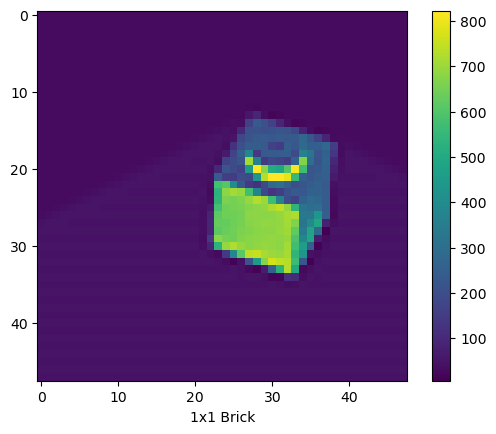

In [7]:
# the same, but with torch dataset
train_dataloader = DataLoader(train_dataset)
images_data, label_data = next(iter(train_dataloader)) 

print('Original shape is ', images_data[0].shape)
plt.figure()
plt.imshow(images_data[0].numpy())
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

In [8]:
# Define a neural network as per the original lab
def build_NN():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    net = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(48*48, 128),
        torch.nn.Sigmoid(),
        torch.nn.Linear(128, 64),
        torch.nn.Sigmoid(),
        torch.nn.Linear(64, 10)
    )
    
    net.apply(init_weights)
    
    return net

In [9]:
from tqdm import tqdm
# lets use some fancy visualization of progress - https://github.com/tqdm/tqdm

In [10]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                # batch x [48, 48, 1] -> batch x [1, 48, 48]
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


In [11]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [12]:
net = build_NN()
print(net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=64, out_features=10, bias=True)
)


In [69]:
# prepare training
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 99, Batch: 14, Loss: 21.98, Acc: 1.00: 100%|██████████| 1500/1500 [00:02<00:00, 660.94it/s]


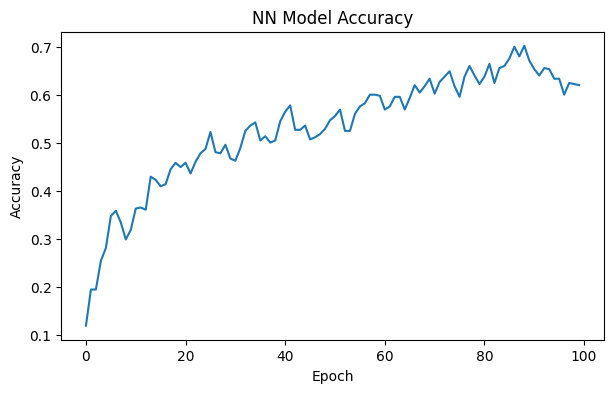

In [70]:
print_history(hist, "NN Model Accuracy")

### Task 1.2 - CNNs (LeNet + AlexNet)

Task: build classic CNN models (LeNet & AlexNet) and apply them for classification

LeNet is a classic neural network, that we can use to validate CNN approach on top of same Lego bricks dataset.
Compare and discuss what are the differences of LeNet & AlexNet architectures.

<br/>
<div>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/1920px-Comparison_image_neural_networks.svg.png" width="800"/>
</div>

In [83]:

def build_lenet():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
        
    net = torch.nn.Sequential(
        # Input: 48x48
    
        torch.nn.Conv2d(1, 6, 5, padding=(2,2)), # out: 48x48x6
        torch.nn.ReLU(),
        
        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 24x24x6
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(6, 16, 5), # out: 20x20x16
        torch.nn.ReLU(),

        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 10x10x16

        torch.nn.Flatten(),
        
        torch.nn.Linear(10*10*16, 120),
        torch.nn.Sigmoid(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )
  
    net.apply(init_weights)
    return net


In [84]:
lenet = build_lenet()
print(lenet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): ReLU()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1600, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)


In [85]:
hist_lenet = train(lenet, train_dataloader, device, EPOCHS, LR)

Epoch: 99, Batch: 14, Loss: 8.40, Acc: 1.00: 100%|██████████| 1500/1500 [00:25<00:00, 58.66it/s] 


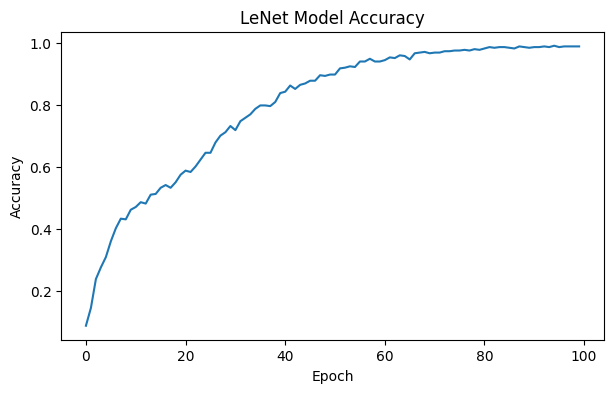

In [86]:
print_history(hist_lenet, "LeNet Model Accuracy")

### Task 1.3 - Evaluate results

Task: Compare NN with given architectures. Discuss, why results are different

In [87]:
def evaluate_acc(net, test_loader, device):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    return acc


In [88]:
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [89]:
net_acc = evaluate_acc(net, test_dataloader, device)
lenet_acc = evaluate_acc(lenet, test_dataloader, device)

print('Test Accuracy (NN): {:.2%}'.format(net_acc))
print('Test Accuracy (LeNet): {:.2%}'.format(lenet_acc))

Test Accuracy (NN): 58.00%
Test Accuracy (LeNet): 100.00%


In [94]:
import itertools

def show_random(net, dataloader):
    train_image_no = 89

    def get_prediction(net, input):
        input = input.permute(2, 0, 1).to(device)
        outputs = net(input)        
        _, predicted = outputs.max(1)
        return predicted


    images_data, original_label = next(iter(dataloader))
    images_data = images_data[0]
    original_label = original_label[0]
    
    predicted_label = get_prediction(net, images_data)
    print('original_label ', original_label) 
    print('predicted_label ', predicted_label)
    if original_label == predicted_label[0]: 
        c = 'green' 
    else:
        c = 'red'
    
    plt.figure()
    plt.imshow(images_data.numpy())
    plt.colorbar()

    plt.xlabel(class_names[predicted_label], color = c)
    plt.show()


original_label  tensor(4)
predicted_label  tensor([4])


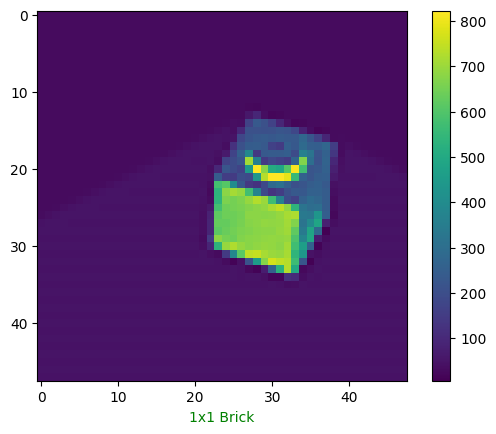

In [95]:
#nn
show_random(net, test_dataloader)

## Part II: Fashion MNIST

Working with small dataset might not be a representable to show CNN benefits.

Lets switch to another dataset - Fashion MNIST. Original Repository - [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)

<br/>
<div>
    <img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png" width="400"/>
</div>
<br/>

To load dataset though the framework, one can use: [https://mxnet.apache.org/versions/1.6/api/python/docs/api/gluon/data/vision/datasets/index.html#mxnet.gluon.data.vision.datasets.FashionMNIST](https://mxnet.apache.org/versions/1.6/api/python/docs/api/gluon/data/vision/datasets/index.html#mxnet.gluon.data.vision.datasets.FashionMNIST)


In [36]:
# Load the training data
fashion_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

fashion_train_data = gluon.data.vision.FashionMNIST(train=True).transform_first(fashion_transformer)
fashion_test_data = gluon.data.vision.FashionMNIST(train=False).transform_first(fashion_transformer)

In [82]:
fashion_batch_size = 512
fashion_epochs = 20

fashion_train_loader = mx.gluon.data.DataLoader(fashion_train_data, batch_size=fashion_batch_size, shuffle=False)
fashion_test_loader = mx.gluon.data.DataLoader(fashion_test_data, batch_size=fashion_batch_size, shuffle=False)

In [37]:
fashion_net = build_NN()

In [49]:
#fashion_batch_size = 512
#fashion_epochs = 200

#fashion_train_loader = mx.gluon.data.DataLoader(fashion_train_data, batch_size=fashion_batch_size, shuffle=False)
#fashion_test_loader = mx.gluon.data.DataLoader(fashion_test_data, batch_size=fashion_batch_size, shuffle=False)

fashion_hist_nn = train(fashion_net, fashion_train_loader, ctx, fashion_epochs)

Epoch: 199, Batch: 117, Loss: 0.057967: 100%|██████████| 23600/23600 [12:23<00:00, 31.73it/s]


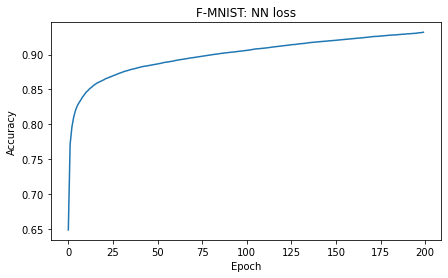

In [50]:
print_history(fashion_hist_nn, "F-MNIST: NN loss")

In [46]:
fashion_lenet = build_lenet()

In [51]:
fashion_hist_lenet = train(fashion_lenet, fashion_train_loader, ctx, fashion_epochs)

Epoch: 199, Batch: 117, Loss: 0.351629: 100%|██████████| 23600/23600 [46:29<00:00,  8.46it/s]


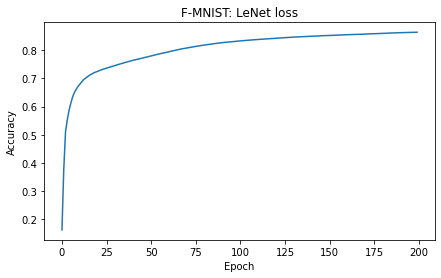

In [52]:
print_history(fashion_hist_lenet, "F-MNIST: LeNet loss")

In [53]:
fashion_net_acc = evaluate_acc(fashion_net, fashion_test_loader)
fashion_lenet_acc = evaluate_acc(fashion_lenet, fashion_test_loader)

print('Validaton Fashion NN: {} = {}'.format(*fashion_net_acc))
print('Validaton Fashion LeNet: {} = {}'.format(*fashion_lenet_acc))

Validaton Fashion NN: accuracy = 0.8914
Validaton Fashion LeNet: accuracy = 0.8561


In [76]:
from mxnet.gluon.model_zoo import vision

In [78]:
fashion_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [80]:
gluon_alexnet = vision.AlexNet(classes = 10)

In [74]:
def build_alexnet():
    net = nn.HybridSequential(prefix='LeNet_')
    with net.name_scope():
        net.add(
            nn.Conv2D(kernel_size=11, strides=(4,4), channels=96, activation="relu"),
            nn.MaxPool2D(pool_size=(3,3), strides=(2,2)),
            nn.Conv2D(kernel_size=5, padding=(2,2), channels=256, activation="relu"),
            nn.MaxPool2D(pool_size=(3,3), strides=(2,2)),
            nn.Conv2D(kernel_size=3, padding=(1,1), channels=384, activation="relu"),
            nn.Conv2D(kernel_size=3, padding=(1,1), channels=384, activation="relu"),
            nn.Conv2D(kernel_size=3, padding=(1,1), channels=256, activation="relu"),
            nn.MaxPool2D(pool_size=(3,3), strides=(2,2)),
            nn.Flatten(),
            nn.Dense(4096, activation='relu'),
            nn.Dropout(0.5),
            nn.Dense(4096, activation='relu'),
            nn.Dropout(0.5),
            nn.Dense(10, activation=None)
        )

    return net

In [72]:
alex_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

alex_train_data = gluon.data.vision.FashionMNIST(train=True).transform_first(fashion_transformer)
alex_test_data = gluon.data.vision.FashionMNIST(train=False).transform_first(fashion_transformer)

alex_train_loader = mx.gluon.data.DataLoader(fashion_train_data, batch_size=fashion_batch_size, shuffle=False)
alex_test_loader = mx.gluon.data.DataLoader(fashion_test_data, batch_size=fashion_batch_size, shuffle=False)

In [69]:
fashion_alexnet = build_alexnet()

In [70]:
print(fashion_alexnet)

HybridSequential(
  (0): Conv2D(None -> 96, kernel_size=(5, 5), stride=(3, 3))
  (1): Activation(relu)
  (2): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (3): Conv2D(None -> 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (4): Activation(relu)
  (5): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (6): Conv2D(None -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (7): Conv2D(None -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (8): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (9): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (10): Flatten
  (11): Dense(None -> 4096, Activation(relu))
  (12): Dropout(p = 0.5, axes=())
  (13): Dense(None -> 4096, Activati

In [81]:
fashion_hist_alexnet = train(gluon_alexnet, alex_train_loader, ctx, 25)

  0%|          | 0/2950 [00:00<?, ?it/s]


MXNetError: Traceback (most recent call last):
  File "../src/operator/nn/pooling.cc", line 193
MXNetError: Check failed: param.kernel[0] <= dshape_nchw[2] + 2 * param.pad[0]: kernel size (3) exceeds input (2 padded to 2)

# Resources

1. d2l book
<div>
    <img src="https://d2l.ai/_images/front.png" width="200"/>
</div>

[https://d2l.ai/index.html](https://d2l.ai/index.html)

2MXNet
<div>
    <img src="https://mxnet.apache.org/versions/1.9.0/assets/img/mxnet_logo.png" width="100"/>
</div>

MXNet provides optimized numerical computation for GPUs and distributed ecosystems, from the comfort of high-level environments like Python and R.
MXNet automates common workflows, so standard neural networks can be expressed concisely in just a few lines of code.

(Source: [https://mxnet.apache.org/](https://mxnet.apache.org/))
<br />

3. Gluon
<div>
    <img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/image-gluon-logo.png" width="200"/>
</div>

[Gluon](https://mxnet.apache.org/versions/1.4.1/gluon/index.html) library in Apache MXNet provides a clear, concise, and simple API for deep learning. It makes it easy to prototype, build, and train deep learning models without sacrificing training speed

(Source: [https://mxnet.apache.org/versions/1.4.1/gluon/index.html](https://mxnet.apache.org/versions/1.4.1/gluon/index.html))
<br />

4. ConvNet Playground
<div>
    <img src="https://convnetplayground.fastforwardlabs.com/images/icon.png" width="100"/>
</div>

[ConvNet Playground](https://convnetplayground.fastforwardlabs.com/#/)
Provides a view on CNN's internals. Discover hidden features & processing though layers

<br />

5. Know Your Data
**Know Your Data** is another bright service that helps one investigate the dataset.
See [https://knowyourdata.withgoogle.com/](https://knowyourdata.withgoogle.com/)